In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, recall_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.model_selection import StratifiedKFold

# Loading and Preparing the Data

In [2]:
mi_h=pd.read_csv("DEMsExpression.csv")
cad=pd.read_csv("MI-Healthy DEMs Expression of CAD samples.csv")
df=pd.concat([mi_h, cad], axis=0)

target = []
for sample in df['Unnamed: 0']:
    if sample[-1] == "H":
        target.append("Healthy")
    elif sample[-1] == "M":
        target.append("MI")
    elif sample[-1] == "C":
        target.append("CAD")

df["MI status"] = target
df.drop('Unnamed: 0', axis=1, inplace = True)

In [3]:
df.head()

,7900488 / MIR30E,7923976 / C1orf132///MIR29B2,7971661 / MIR15A,7976832 / MIR323A,8008885 / MIR21,8045453 / MIR128-1,8084755 / MIR28,8087881 / MIRLET7G,8163107 / MIR32,8175248 / MIR92A2,MI status
0,5.86237,4.17884,5.93182,3.31011,8.79683,4.71189,3.45519,7.52580,6.67709,3.16477,Healthy
1,5.61056,3.90262,6.09685,3.54984,9.09161,4.82916,3.52235,7.55883,6.60037,3.14140,Healthy
2,6.47634,4.42823,6.45591,3.78296,9.46479,4.56398,3.64562,7.69815,6.91699,3.05517,Healthy
3,6.29086,4.16566,6.38480,3.47636,9.16028,4.41579,3.72838,7.59828,6.30052,3.05037,Healthy
4,5.42813,3.83066,6.30655,3.82938,8.31414,4.49369,3.53013,7.36374,6.18958,2.99243,Healthy


In [4]:
df.shape

(250, 11)

# Exploratory Data Analysis

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
7900488 / MIR30E,250.0,7.450548,0.607236,5.356128,7.199537,7.633360,7.867915,8.360230
7923976 / C1orf132///MIR29B2,250.0,5.384517,0.655981,3.628750,5.232723,5.600820,5.820860,6.509030
7971661 / MIR15A,250.0,6.990930,0.600481,5.072702,6.717252,7.124750,7.360918,8.311290
7976832 / MIR323A,250.0,3.548375,0.548304,2.870420,3.200370,3.345095,3.610920,5.171396
8008885 / MIR21,250.0,10.115399,0.952993,6.982273,9.503113,10.320200,10.771200,12.349500
8045453 / MIR128-1,250.0,5.643931,0.556826,4.081839,5.548987,5.816710,6.024390,6.386390
8084755 / MIR28,250.0,5.181250,0.812016,3.365152,5.001390,5.478615,5.723738,6.492950
8087881 / MIRLET7G,250.0,7.821840,0.667161,5.664453,7.559920,7.975815,8.265690,9.254780
8163107 / MIR32,250.0,7.565765,0.821758,4.744559,7.351542,7.817910,8.111895,8.957920
8175248 / MIR92A2,250.0,2.938011,0.435897,2.463260,2.647992,2.757300,2.960275,4.055258


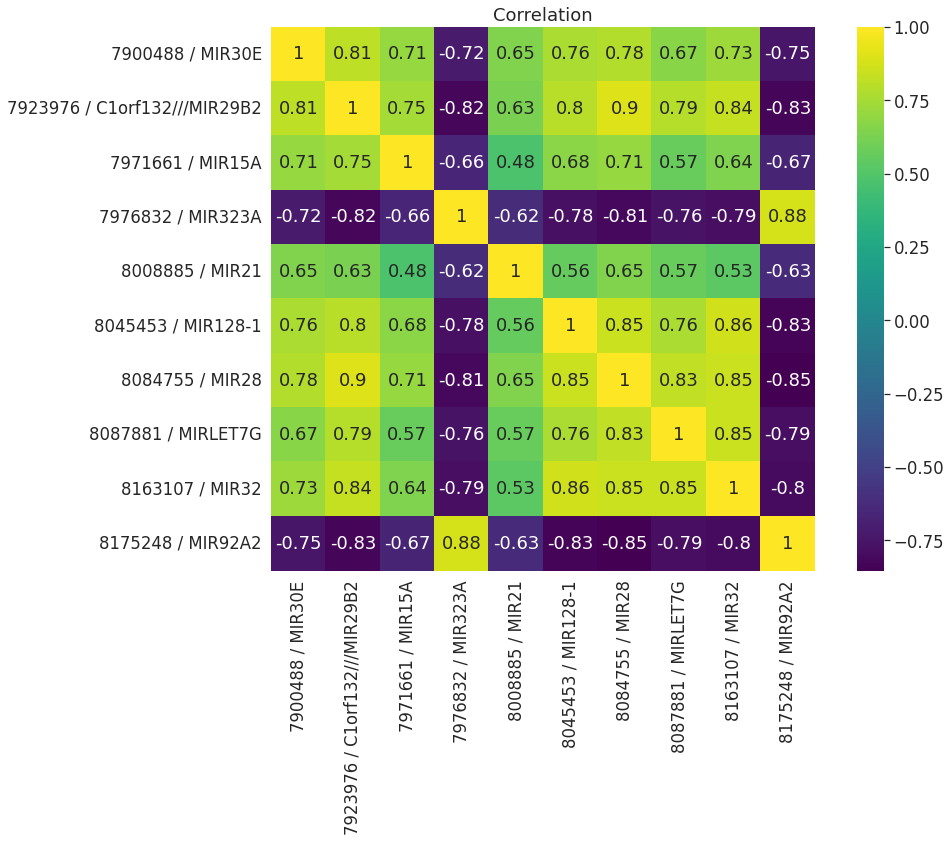

<Figure size 432x288 with 0 Axes>

In [7]:
plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)
sns.heatmap(df.corr(),vmax=1,square=True, annot=True, cmap='viridis')
plt.title('Correlation')
plt.show()
plt.savefig('corrforall.pdf', bbox_inches='tight')

In [8]:
df_melt=pd.melt(df, id_vars='MI status')

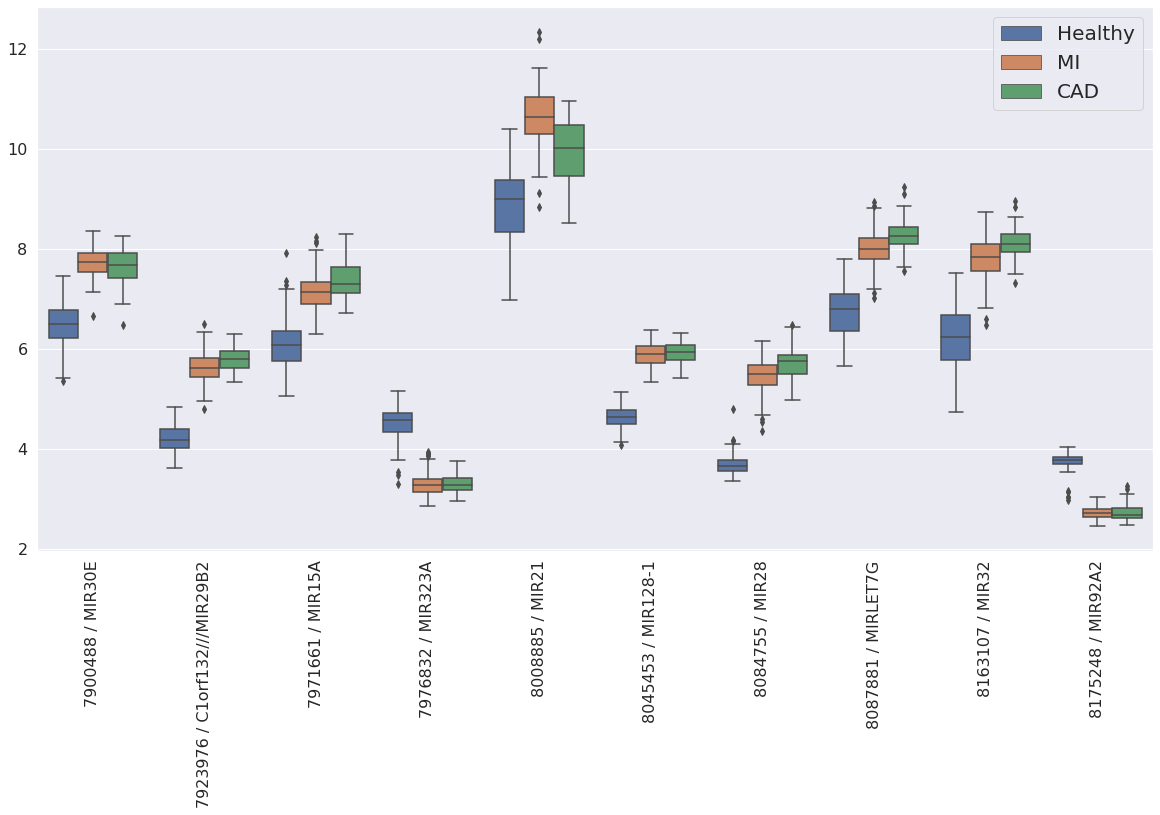

In [9]:
plt.figure(figsize=(20,10))
sns.boxplot(x="variable", y="value", hue='MI status', data=df_melt);
plt.ylabel('', fontsize = 20)
plt.xlabel('', fontsize = 20)
plt.legend(loc='upper right', prop={'size':20})
plt.tick_params(axis='x', which='major', labelsize=15, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('Expressionforall.pdf', bbox_inches='tight')

## Adding a target columns for further use

In [10]:
df['H or M/C']=df['MI status']
df['H or M/C'][df['H or M/C'] != 'Healthy'] = 'Not_Healthy'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Healthy or MI/CAD

In [16]:
scoring = ['precision_weighted', 'accuracy']

In [17]:
mirs=list(df.columns)[0:10]
result=[]
for mir in mirs:
  X_temp=pd.DataFrame(df[mir])
  y_temp = df['H or M/C']
  cv=StratifiedKFold(n_splits=10)
  svm=SVC(kernel='linear', random_state=1)
  scores = cross_validate(svm, X_temp, y_temp, scoring=scoring, cv=cv,
                          n_jobs=-1, return_train_score=True)
  scores=pd.DataFrame(scores)
  result.append([mir, list(scores.mean(axis=0))])

In [20]:
result

[['7900488 / MIR30E',
  [0.008051681518554687,
   0.007809233665466308,
   0.9466103896103896,
   0.9473745210388284,
   0.9440000000000002,
   0.9480000000000001]],
 ['7923976 / C1orf132///MIR29B2',
  [0.00880570411682129,
   0.007633185386657715,
   0.9893939393939395,
   0.996520300133621,
   0.9880000000000001,
   0.9964444444444445]],
 ['7971661 / MIR15A',
  [0.008609914779663086,
   0.008415627479553222,
   0.9445089542036911,
   0.9520049976637106,
   0.9440000000000002,
   0.952]],
 ['7976832 / MIR323A',
  [0.006073999404907227,
   0.004375147819519043,
   0.9841666666666666,
   0.9796831448792054,
   0.9800000000000001,
   0.979111111111111]],
 ['8008885 / MIR21',
  [0.0054311990737915036,
   0.004411101341247559,
   0.8832087960348829,
   0.878586562012765,
   0.852,
   0.8844444444444444]],
 ['8045453 / MIR128-1',
  [0.004654383659362793, 0.004415464401245117, 1.0, 1.0, 1.0, 1.0]],
 ['8084755 / MIR28',
  [0.005996346473693848,
   0.003936982154846192,
   0.9928571428571429,


The best candidates are mir-128-1 with all 0.99 scores and mir-323a with scores near 0.98, and mir-29B2  over 0.99 and 92A2 = 98. It should be mentioned that the data is highly imbalanced.

In [ ]:
cross_val_predict

# MI/CAD

In [22]:
df_mc=df[df['MI status'] != 'Healthy']
X=df_mc.drop(['MI status', 'H or M/C'], axis=1)
y=df_mc['MI status']

In [23]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [24]:
X=pd.concat([X_train,y_train],axis=1)
X['MI status'].value_counts()

MI     97
CAD    42
Name: MI status, dtype: int64

## Resampling for handling imbalanced data

In [25]:
MI=X[X['MI status'] == 'MI']
CAD=X[X['MI status'] == 'CAD']

In [26]:
#less_MI=resample(MI, replace=False, n_samples=90, random_state=4)
more_CAD=resample(CAD,replace=True, n_samples=97, random_state=1)

df_resample=pd.concat([more_CAD,MI])

In [27]:
df_resample['MI status'].value_counts()

CAD    97
MI     97
Name: MI status, dtype: int64

## Training all possible combinations with 3 miRs

In [29]:
mirs=list(df_resample.columns)[0:10]
listOf3Combinations=[]
for i in range(len(mirs)):
  for j in range(i+1,len(mirs)):
    for k in range(j+1,len(mirs)):
      listOf3Combinations.append([mirs[i], mirs[j], mirs[k]])

len(listOf3Combinations)

120

In [72]:
#defining scoring for all furthur uses in cross validation
scoring = ['precision_weighted', 'accuracy']

In [73]:
result3=pd.DataFrame(columns=['test_precision_weighted', 'train_precision_weighted', 'test_accuracy', 'train_accuracy'])
for i in range(len(listOf3Combinations)):
  mir_comb=listOf3Combinations[i]
  X_temp = df_resample[mir_comb]
  y_temp = df_resample['MI status']
  svm=SVC(C=1000, gamma=0.05, kernel='rbf', random_state=1)
  scores = cross_validate(svm, X_temp, y_temp, scoring=scoring, cv=10,
                          n_jobs=-1, return_train_score=True)
  mean_scores=pd.DataFrame(pd.DataFrame(scores).mean(axis=0)[2:6], columns=[str(mir_comb)]).T
  result3=pd.concat([result3, mean_scores])

In [77]:
result3

,test_precision_weighted,train_precision_weighted,test_accuracy,train_accuracy
"['7900488 / MIR30E', '7923976 / C1orf132///MIR29B2', '7971661 / MIR15A']",0.738853,0.751555,0.730789,0.747984
"['7900488 / MIR30E', '7923976 / C1orf132///MIR29B2', '7976832 / MIR323A']",0.671126,0.702634,0.665000,0.702184
"['7900488 / MIR30E', '7923976 / C1orf132///MIR29B2', '8008885 / MIR21']",0.833705,0.830728,0.825000,0.830479
"['7900488 / MIR30E', '7923976 / C1orf132///MIR29B2', '8045453 / MIR128-1']",0.708537,0.700289,0.700263,0.699865
"['7900488 / MIR30E', '7923976 / C1orf132///MIR29B2', '8084755 / MIR28']",0.780224,0.772944,0.767368,0.772614
...,...,...,...,...
"['8045453 / MIR128-1', '8163107 / MIR32', '8175248 / MIR92A2']",0.676075,0.681889,0.643684,0.652916
"['8084755 / MIR28', '8087881 / MIRLET7G', '8163107 / MIR32']",0.769505,0.782652,0.753421,0.768627
"['8084755 / MIR28', '8087881 / MIRLET7G', '8175248 / MIR92A2']",0.714722,0.727783,0.696053,0.719373
"['8084755 / MIR28', '8163107 / MIR32', '8175248 / MIR92A2']",0.739425,0.739737,0.711842,0.715931


## Training all possible combinations with 4 miRs

In [79]:
mirs=list(df_resample.columns)[0:10]
listOf4Combinations=[]
for i in range(len(mirs)):
  for j in range(i+1,len(mirs)):
    for k in range(j+1,len(mirs)):
      for h in range(k+1,len(mirs)):
        listOf4Combinations.append([mirs[i], mirs[j], mirs[k], mirs[h]])

len(listOf4Combinations)

210

In [80]:
#defining scoring for all furthur uses in cross validation
scoring = ['precision_weighted', 'accuracy']

In [81]:
result4=pd.DataFrame(columns=['test_precision_weighted', 'train_precision_weighted', 'test_accuracy', 'train_accuracy'])
for i in range(len(listOf4Combinations)):
  mir_comb=listOf4Combinations[i]
  X_temp = df_resample[mir_comb]
  y_temp = df_resample['MI status']
  svm=SVC(C=1000, gamma=0.05, kernel='rbf', random_state=1)
  scores = cross_validate(svm, X_temp, y_temp, scoring=scoring, cv=10,
                          n_jobs=-1, return_train_score=True)
  mean_scores=pd.DataFrame(pd.DataFrame(scores).mean(axis=0)[2:6], columns=[str(mir_comb)]).T
  result4=pd.concat([result4, mean_scores])

In [82]:
result4

,test_precision_weighted,train_precision_weighted,test_accuracy,train_accuracy
"['7900488 / MIR30E', '7923976 / C1orf132///MIR29B2', '7971661 / MIR15A', '7976832 / MIR323A']",0.784353,0.802130,0.772368,0.795530
"['7900488 / MIR30E', '7923976 / C1orf132///MIR29B2', '7971661 / MIR15A', '8008885 / MIR21']",0.838163,0.860528,0.825263,0.859113
"['7900488 / MIR30E', '7923976 / C1orf132///MIR29B2', '7971661 / MIR15A', '8045453 / MIR128-1']",0.767267,0.783835,0.752105,0.781777
"['7900488 / MIR30E', '7923976 / C1orf132///MIR29B2', '7971661 / MIR15A', '8084755 / MIR28']",0.789130,0.805247,0.777632,0.802969
"['7900488 / MIR30E', '7923976 / C1orf132///MIR29B2', '7971661 / MIR15A', '8087881 / MIRLET7G']",0.828530,0.847931,0.813158,0.845343
...,...,...,...,...
"['8045453 / MIR128-1', '8084755 / MIR28', '8087881 / MIRLET7G', '8163107 / MIR32']",0.753503,0.781307,0.738158,0.771501
"['8045453 / MIR128-1', '8084755 / MIR28', '8087881 / MIRLET7G', '8175248 / MIR92A2']",0.734926,0.762309,0.716842,0.752598
"['8045453 / MIR128-1', '8084755 / MIR28', '8163107 / MIR32', '8175248 / MIR92A2']",0.721742,0.749760,0.690789,0.731396
"['8045453 / MIR128-1', '8087881 / MIRLET7G', '8163107 / MIR32', '8175248 / MIR92A2']",0.711148,0.754977,0.705526,0.747425


## Nested Cross_Validation for the best combinations

In [104]:
best_mirs=['7900488 / MIR30E', '7923976 / C1orf132///MIR29B2', '8008885 / MIR21', '8087881 / MIRLET7G']
X_temp = df_resample[best_mirs]
y_temp = df_resample['MI status']

In [105]:
# configure the cross-validation procedure
cv_inner = KFold(n_splits=10, shuffle=True, random_state=1)
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)

In [85]:
model = SVC(random_state=1)
param_grid = {
  'C': [1, 10, 100, 1000, 2000, 10000],
  'gamma': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.1],
  'kernel': ['rbf', 'linear', 'sigmoid']
}

In [86]:
search = GridSearchCV(model, param_grid, n_jobs=-1, cv=cv_inner, refit=True)
scores = cross_validate(search, X_temp, y_temp, scoring=scoring, 
                        cv=cv_outer, n_jobs=-1, return_train_score=True, 
                        return_estimator =True)

In [87]:
scores=pd.DataFrame(scores)
scores_mean=list(scores.mean(axis=0))
scores_mean

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


[30.472935271263122,
 0.01032693386077881,
 0.8772365755589441,
 0.9140992105218638,
 0.8710526315789474,
 0.9129458128078817]

In [106]:
svm=SVC(C=1100, gamma=0.05, kernel='rbf', random_state=1)
scores = cross_validate(svm, X_temp, y_temp, scoring=scoring, cv=10,
                          n_jobs=-1, return_train_score=True, return_estimator=True)
scores=pd.DataFrame(scores)

In [107]:
scores

,fit_time,score_time,estimator,test_precision_weighted,train_precision_weighted,test_accuracy,train_accuracy
0,0.007846,0.005001,"SVC(C=1100, gamma=0.05, random_state=1)",0.853535,0.915164,0.850000,0.913793
1,0.013803,0.005045,"SVC(C=1100, gamma=0.05, random_state=1)",0.853535,0.879762,0.850000,0.879310
2,0.007516,0.004583,"SVC(C=1100, gamma=0.05, random_state=1)",0.853535,0.904920,0.850000,0.902299
3,0.007041,0.004334,"SVC(C=1100, gamma=0.05, random_state=1)",1.000000,0.891270,1.000000,0.890805
4,0.007508,0.004357,"SVC(C=1100, gamma=0.05, random_state=1)",0.912281,0.909451,0.894737,0.908571
5,0.007753,0.004331,"SVC(C=1100, gamma=0.05, random_state=1)",0.952153,0.886552,0.947368,0.885714
6,0.007478,0.004242,"SVC(C=1100, gamma=0.05, random_state=1)",0.894737,0.910536,0.894737,0.908571
7,0.007236,0.004088,"SVC(C=1100, gamma=0.05, random_state=1)",0.845096,0.911971,0.842105,0.908571
8,0.006431,0.005381,"SVC(C=1100, gamma=0.05, random_state=1)",0.854251,0.904146,0.789474,0.902857
9,0.008136,0.004340,"SVC(C=1100, gamma=0.05, random_state=1)",0.952632,0.897948,0.947368,0.897143


In [89]:
list(scores.mean(axis=0))

[0.009103131294250489,
 0.004607248306274414,
 0.8971754999386578,
 0.901171965602096,
 0.8865789473684209,
 0.8997635467980294]

In [91]:
model=SVC(C=1100, gamma=0.05, kernel='rbf', random_state=1).fit(X_temp, y_temp)

In [92]:
model.score(X_temp, y_temp)

0.8917525773195877

In [93]:
model.score(X_test[best_mirs], y_test)

0.7666666666666667

In [94]:
pred=model.predict(X_test[best_mirs])

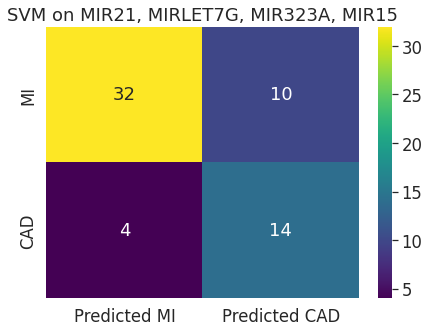

In [95]:
cm=confusion_matrix(y_test,pred,labels=['MI', 'CAD'])
df_cm=pd.DataFrame(cm,index=[i for i in ['MI', 'CAD']],columns=[i for i in ['Predicted MI', 'Predicted CAD']])
plt.figure(figsize=(7,5))
plt.title('SVM on MIR21, MIRLET7G, MIR323A, MIR15')
sns.heatmap(df_cm,annot=True, cmap='viridis');

In [96]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         CAD       0.58      0.78      0.67        18
          MI       0.89      0.76      0.82        42

    accuracy                           0.77        60
   macro avg       0.74      0.77      0.74        60
weighted avg       0.80      0.77      0.77        60



In [97]:
label = LabelEncoder()

y_temp = label.fit_transform(df_resample['MI status'])
y_temp = pd.get_dummies(y_temp)
y_temp.columns = ['CAD', 'MI']

n_classes = y_temp.shape[1]

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=.25, random_state=27)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(SVC(C=1000, gamma=0.05, kernel='rbf', random_state=27))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  


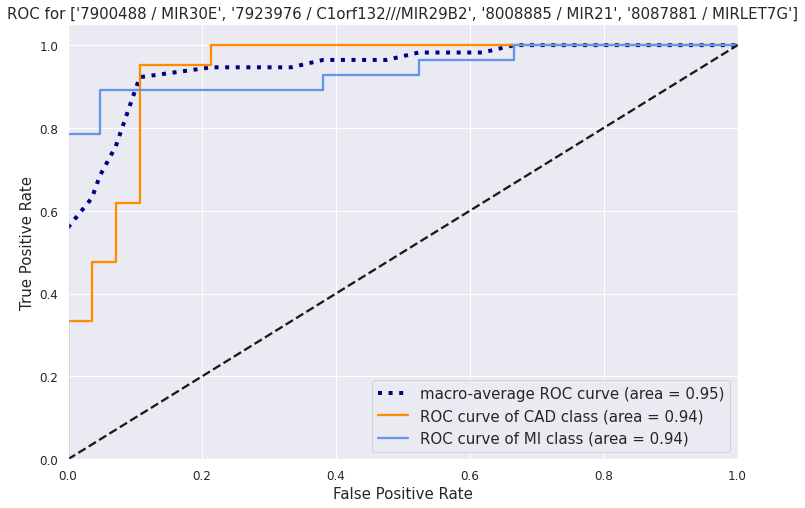

In [99]:
lw = 2.3
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    
# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,8))

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(['darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} class (area = {1:0.2f})'
             ''.format(list(y_temp.columns)[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.title('ROC for {0}'''.format(list(X_temp.columns)), fontsize = 15)
plt.legend(loc="lower right", prop={'size':15})
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("323a, 21, 15A, let7g.pdf")